# First Models (first approach)

## Libraries

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

## Paths

In [9]:
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

## Separar las features del target

- Separar las features (valores de la primera sesión) y el target (valores de la última sesión).
- Los valores de la primera sesión corresponden a las filas impares y los valores de la última sesión corresponden a las filas pares. 

In [10]:
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

Now, my train and test sets contain 101 columns (from F_AP_PRO_1 to F_AP_PRO_101).
Each patient has 2 rows: the first one is the first session, and the second one is the last session (the second row per patient (last session) is the one we want to predict. It is our outcome).

In the dataset there are the right and left legs.  We consider each leg as a different observation, as if we have a new measurement. We interpret it as another patient. The idea now is to make a simple dataset where I have the first session per patient and leg, each leg is like a different patient, and because there is a variation, at the end we have more data. We make an assumption: we consider that they are independent measurements, so it doesn't matter if we put the left and right leg values in this order or if we put the left leg dataset under the right leg dataset. So, in this case, we put the left leg dataset under the right leg dataset.

To split the datasets: 
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test


So now, X_train contains the first session of the patients (right and left legs) and y_train contains the last session of the patients (right and left legs), which is what we want to predict. 

To predict the last sessions of the patients (predict 101 variables), I want to perform a multiple linear regression. Check the assumptions of the multiple linear regression for my case. 


## ANKLE data - 2 sessions

### Load preprocessed data

In [11]:
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

### EDA

In [41]:
def explore_data(df: pd.DataFrame) -> None:
    """
    Takes in a pandas DataFrame and performs exploratory data analysis.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to be analyzed.

    Returns:
    --------
    None
    """

    # Print the dimensions of the DataFrame
    print(f"The dataset includes {df.shape[0]} instances (rows) and {df.shape[1]} variables (columns).\n")

    # Display the first few rows of the DataFrame
    display(df.head())
    print("\n")

    # Print the column information for the DataFrame
    print(df.info())
    print("\n")
    
    # Check missing values
    print(f"Missing values: \n{df.isna().sum()}")
    print("\n")

    # Select only the numeric features
    numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate the descriptive statistics for the numeric variables
    display(df[numeric_vars].describe())
    
    # Check duplicates
    print(f"\n Number of duplicates: {df.duplicated().sum()}")


In [42]:
# EDA train df 
explore_data(combined_legs_2sessions_A_train)

The dataset includes 360 instances (rows) and 104 variables (columns).



SUBJECT_ID  SESSION_ID  TRIAL_ID  F_AP_PRO_1  F_AP_PRO_2  F_AP_PRO_3  \
0        1746       11976  5.500000   -0.004533   -0.000129    0.005483   
1        1746       12037  5.625000   -0.006869   -0.000890    0.008038   
2        1748       18454  5.166667    0.009228    0.018207    0.020520   
3        1748       18518  6.333333    0.016802    0.027338    0.030654   
4        1751       34346  4.666667    0.008917    0.019561    0.026497   

   F_AP_PRO_4  F_AP_PRO_5  F_AP_PRO_6  F_AP_PRO_7  ...  F_AP_PRO_92  \
0    0.003821   -0.008103   -0.025409   -0.043892  ...     0.138415   
1    0.011478    0.004346   -0.011274   -0.031441  ...     0.150356   
2    0.009092   -0.014986   -0.041766   -0.062416  ...     0.118068   
3    0.021135   -0.001506   -0.029649   -0.053990  ...     0.078602   
4    0.022526    0.007073   -0.015679   -0.040577  ...     0.187439   

   F_AP_PRO_93  F_AP_PRO_94  F_AP_PRO_95  F_AP_PRO_96  F_AP_PRO_97  \
0     0.115237     0.091950     0.069681     0.049360     0.031920   
1     0.125413     0.100498     0.076889     0.055665     0.037796   
2     0.109534     0.097488     0.081554     0.063031     0.044676   
3     0.073529     0.066233     0.056173     0.043774     0.030571   
4     0.158961     0.127539     0.097307     0.071881     0.052150   

   F_AP_PRO_98  F_AP_PRO_99  F_AP_PRO_100  F_AP_PRO_101  
0     0.018096     0.007602     -0.000017     -0.004173  
1     0.023901     0.013749      0.006494      0.001724  
2     0.029247     0.017662      0.009402      0.003762  
3     0.018634     0.009330      0.002944     -0.000842  
4     0.037216     0.025276      0.014959      0.006287  

[5 rows x 104 columns]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Columns: 104 entries, SUBJECT_ID to F_AP_PRO_101
dtypes: float64(102), int64(2)
memory usage: 292.6 KB
None


Missing values: 
SUBJECT_ID      0
SESSION_ID      0
TRIAL_ID        0
F_AP_PRO_1      0
F_AP_PRO_2      0
               ..
F_AP_PRO_97     0
F_AP_PRO_98     0
F_AP_PRO_99     0
F_AP_PRO_100    0
F_AP_PRO_101    0
Length: 104, dtype: int64




SUBJECT_ID    SESSION_ID    TRIAL_ID  F_AP_PRO_1  F_AP_PRO_2  \
count   360.000000    360.000000  360.000000  360.000000  360.000000   
mean   2041.900000  23165.683333    5.717586    0.006228    0.017233   
std     182.899583   8546.537679    0.897124    0.009102    0.014907   
min    1746.000000   9183.000000    3.200000   -0.041898   -0.043405   
25%    1893.000000  16623.250000    5.321429    0.000654    0.007306   
50%    2037.000000  21137.500000    5.500000    0.006620    0.018429   
75%    2192.000000  28732.750000    6.000000    0.012475    0.027298   
max    2388.000000  42415.000000   10.500000    0.029839    0.075552   

       F_AP_PRO_3  F_AP_PRO_4  F_AP_PRO_5  F_AP_PRO_6  F_AP_PRO_7  ...  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  ...   
mean     0.025538    0.022492    0.006169   -0.017128   -0.039761  ...   
std      0.020506    0.024690    0.028229    0.031147    0.033066  ...   
min     -0.050440   -0.055000   -0.085972   -0.124570   -0.157650  ...   
25%      0.011437    0.008140   -0.009793   -0.036797   -0.060703  ...   
50%      0.026186    0.021032    0.005960   -0.014622   -0.035754  ...   
75%      0.038459    0.037601    0.024731    0.004225   -0.015732  ...   
max      0.114322    0.114127    0.083398    0.050188    0.031266  ...   

       F_AP_PRO_92  F_AP_PRO_93  F_AP_PRO_94  F_AP_PRO_95  F_AP_PRO_96  \
count   360.000000   360.000000   360.000000   360.000000   360.000000   
mean      0.126349     0.109956     0.091170     0.071413     0.052337   
std       0.041744     0.037981     0.033674     0.029004     0.024154   
min       0.015601     0.013070     0.009765     0.005729     0.001160   
25%       0.100986     0.084816     0.068533     0.051972     0.034312   
50%       0.127283     0.109711     0.088931     0.068089     0.049651   
75%       0.151618     0.134908     0.113216     0.090112     0.066668   
max       0.241565     0.215433     0.185459     0.153900     0.122728   

       F_AP_PRO_97  F_AP_PRO_98  F_AP_PRO_99  F_AP_PRO_100  F_AP_PRO_101  
count   360.000000   360.000000   360.000000    360.000000    360.000000  
mean      0.035391     0.021453     0.010805      0.003317     -0.001221  
std       0.019438     0.015264     0.011841      0.009119      0.006816  
min      -0.003546    -0.009131    -0.013964     -0.015525     -0.017125  
25%       0.021260     0.010637     0.002518     -0.003148     -0.006135  
50%       0.034401     0.020827     0.010170      0.002345     -0.001524  
75%       0.045197     0.029295     0.017433      0.009083      0.003116  
max       0.093864     0.068651     0.047458      0.030589      0.021965  

[8 rows x 104 columns]


 Number of duplicates: 0


### Train - Test split

In [12]:
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(
                                                df_train = combined_legs_2sessions_A_train, 
                                                df_test = combined_legs_2sessions_A_test)

## Multiple Linear Regression 

Combinaciones: 
- Regresión lineal múltiple con la X e Y sin reducir.
- Regresión lineal múltiple con PCA de la X (reducida) e Y sin reducir.
- Regresión lineal múltiple con la X sin reducir y con PCA de la Y (reducida).
- Regresión lineal múltiple con con PCA de la X e Y (las dos reducidas)


### Assumptions

Assumption of Regression Model :

- Linearity: The relationship between dependent and independent variables should be linear.
- Homoscedasticity: Constant variance of the errors should be maintained.
- Multivariate normality: Multiple Regression assumes that the residuals are normally distributed.
- Lack of Multicollinearity: It is assumed that there is little or no multicollinearity in the data.

#### Linealidad 

Most common way to check linearity is to scatter-plot residuals (studentized preferably) against the linearly predicted values. Curved or non-horizontally spead cloud on such a plot is diagnostic for non-linearity. To uncover more hidden (partial) non-linearity plot the residuals against each of the predictors. 
- https://stats.stackexchange.com/questions/70009/how-do-you-check-the-linearity-of-a-multiple-regression

Residual Plots: After fitting the multiple linear regression model, you can create scatterplots of the residuals against each independent variable. This can provide insights into any non-linear patterns or heteroscedasticity. For a large number of variables, it may be more manageable to focus on variables with higher importance or those that are theoretically expected to have a significant impact on the outcome.




### Model 1: Multiple Linear Regression con la X e y sin reducir

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


In [14]:
# Fit the multiple linear regression model using the training data:
model_A2 = LinearRegression()
model_A2.fit(X_train_A2, y_train_A2)

LinearRegression()

In [15]:
# Calculate the linearly predicted values
y_train_A2_predicted = model_A2.predict(X_train_A2)

In [16]:
# Calculate the residuals (difference between the observed and predicted values)
residuals_A2 = y_train_A2 - y_train_A2_predicted

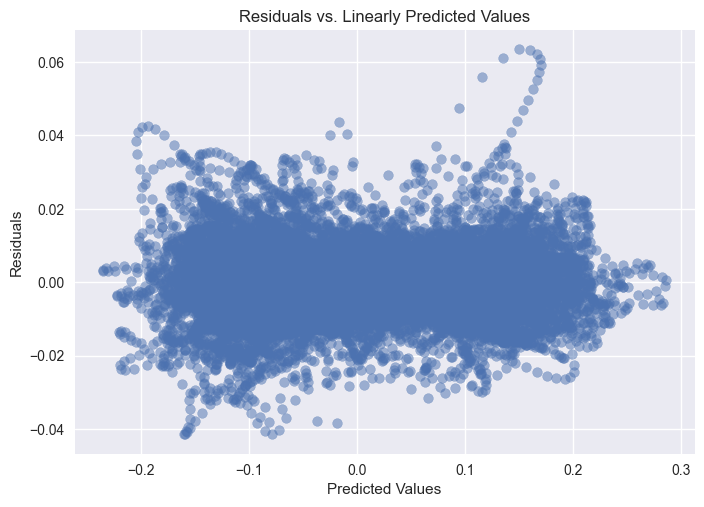

In [17]:
# Scatterplot of residuals against linearly predicted values
plt.scatter(y_train_A2_predicted, residuals_A2, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Linearly Predicted Values")
plt.show()

- Linearity: Look for a random scatter of points around the horizontal line (y = 0). If the points exhibit a clear pattern or show a non-linear relationship, it suggests a violation of the linearity assumption.



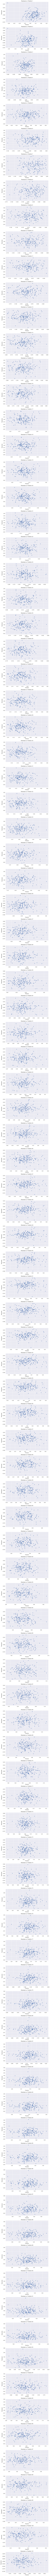

In [24]:
# Scatterplot of residuals against individual predictors:
num_predictors = X_train_A2.shape[1] # 101 predictors
fig, axs = plt.subplots(num_predictors, figsize=(8, num_predictors * 4))
for i in range(num_predictors):
    axs[i].scatter(X_train_A2[:, i], residuals_A2[:, i], alpha=0.5)
    axs[i].set_xlabel("Predictor")
    axs[i].set_ylabel("Residuals")
    axs[i].set_title(f"Residuals vs. Predictor {i+1}")
plt.tight_layout()
plt.show()


In [26]:
cv_scores = cross_val_score(model_A2, X_train_A2, y_train_A2, cv=10, scoring='neg_mean_squared_error')


In [27]:
cv_mse = -cv_scores
cv_rmse = np.sqrt(cv_mse)

In [28]:
y_pred_A2 = model_A2.predict(X_test_A2)
test_mse = mean_squared_error(y_test_A2, y_pred_A2)
test_rmse = np.sqrt(test_mse)


In [29]:
print("Cross-validated RMSE:", cv_rmse.mean())
print("Test set RMSE:", test_rmse)

Cross-validated RMSE: 0.027673307958552495
Test set RMSE: 0.021544001275171077


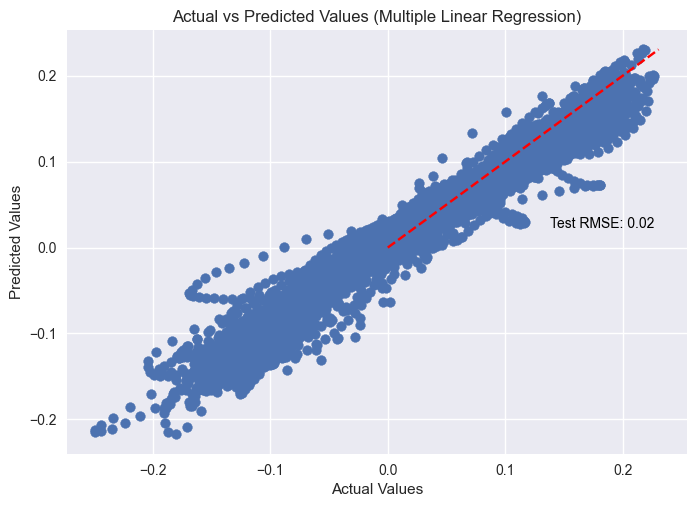

In [37]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test_A2, y_pred_A2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Multiple Linear Regression)')

# Plot a diagonal line for reference
max_value = max(y_test_A2.max(), y_pred_A2.max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Display RMSE as text
plt.text(max_value * 0.6, max_value * 0.1, f'Test RMSE: {test_rmse:.2f}', color='black')

# Show the plot
plt.show()
